# Separate cluster label into individual cells

### Load libraries and functions

In [ ]:
from skimage.io import imread, imsave, imshow
from skimage.measure import label
from skimage.segmentation import relabel_sequential, watershed
from skimage.morphology import erosion
import numpy as np
import os
import matplotlib.pyplot as plt

# Suppress warnings for low contrast images
import warnings

warnings.filterwarnings("ignore", message=".*is a low contrast image.*")


# Define functions for image processing and visualization
def display_label_array(label_array, title):
    """
    Display a 3D label array as a series of 2D slices.

    Parameters:
    - label_array: 3D numpy array with labeled connected components.
    """
    if label_array.ndim == 2:
        # Create subplots
        fig, axes = plt.subplots(1, 1, figsize=(15, 5))
        (imshow(label_array, cmap="Wistia"))

    elif label_array.ndim != 3:
        raise ValueError("Input label_array must be 2D or 3D.")

    elif label_array.ndim == 3:
        # Number of slices to display
        num_slices = label_array.shape[0]

        # Create subplots
        fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

        for z in range(num_slices):
            axes[z].imshow(
                label_array[z, :, :], cmap="gray", vmin=0, vmax=label_array.max()
            )
            if z == 0:
                axes[z].set_title(title)
            else:
                axes[z].set_title(f"z={z}")
            axes[z].axis("off")  # Hide axes for cleaner visualization

    plt.show()


def is_label_image(image):
    if np.issubdtype(image.dtype, np.integer) and len(np.unique(image)) < 256:
        return True
    return False


def get_label_indices(directory, label_image_name):
    """
    Get the indices of labeled regions in a label image.

    Parameters:
    - directory: Directory containing the label image.
    - label_image_name: Name of the label image file.

    Returns:
    - label_indices: List of unique labels in the label image.
    - original_array_shape: Shape of the original label array.
    """
    # Read the label image
    lbl_array = imread(
        os.path.join(directory, label_image_name),
    )
    # get the shape of the label array
    original_array_shape = lbl_array.shape

    # Check if label image or regular image
    if is_label_image(lbl_array):
        # If label image, use it as is
        lbl_array = lbl_array.astype(np.uint8)
    else:
        # If regular image, return None
        return None, original_array_shape

    # Get a list of unique labels in the label array
    lbl_list = np.unique(lbl_array)
    # Get the indices of the labels in the label array
    lbl_idx_list = [np.where(lbl_array == lbl) for lbl in lbl_list if lbl != 0]

    return lbl_idx_list, original_array_shape


def calculate_connected_components(label_array):
    """
    Calculate the number of connected components in each z-slice of a 3D label array.

    Parameters:
    - label_array: 3D numpy array with labeled connected components.

    Returns:
    - connected_components_list: List of the number of connected components in each slice.
    - cc_array: 3D numpy array with connected components labeled.
    """
    # Create a list to store the number of connected components for each slice
    connected_components_list = []

    # Initialize a zero array for connected components
    cc_array = np.zeros(label_array.shape, dtype=np.uint8)

    # Compute connected components for each slice
    for z in range(label_array.shape[0]):
        # Get the connected components for the current slice
        connected_components, a, b = relabel_sequential(
            label(label_array[z, :, :], connectivity=1)
        )
        # Store the connected components in the cc_array
        cc_array[z, :, :] = connected_components
        # Get the number of connected components and append to the list
        connected_components_list.append(connected_components.max())

    return connected_components_list, cc_array


def generate_label_marker_array(
    label_array, cc_array, max_connected_components_idx, z_center
):
    """
    Generate a marker array for watershed segmentation.

    Parameters:
    - label_array: 3D numpy array with object labels.
    - cc_array: 3D numpy array with connected components labeled.
    - max_connected_components_idx: Indices of slices with the maximum number of connected components.
    - z_center: Center slice index for the label array.

    Returns:
    - marker_array: 3D numpy array with markers for watershed segmentation.
    """
    # Create a marker array with the same shape as the label array
    marker_array = np.zeros(label_array.shape, dtype=np.uint8)

    # If there is only one slice with the maximum number of connected components
    # Use that slice for the watershed algorithm
    if len(max_connected_components_idx) == 1:
        # Get the slice with the maximum number of connected components
        marker_array_raw = cc_array[max_connected_components_idx[0], :, :]
        # Erode the marker array to remove small components
        # This is done to ensure that the markers are not too close to each other
        marker_array_raw = erosion(marker_array_raw, footprint=np.ones((3, 3)))

        if abs(max_connected_components_idx[0] - z_center) < 3:
            z_position = max_connected_components_idx[0]
        else:
            z_position = z_center

        marker_array[z_position, :, :] = marker_array_raw

    # If there are multiple slices with the same maximum number of connected components
    # Use the slice closest to the center of the label
    else:
        # If there are multiple slices with the same maximum number of connected components
        # Use one closest to the center of the label -> z_center
        closest_slice_idx = min(
            max_connected_components_idx, key=lambda idx: abs(idx - z_center)
        )

        marker_array_raw = cc_array[closest_slice_idx, :, :]

        marker_array_raw = erosion(marker_array_raw, footprint=np.ones((3, 3)))
        marker_array[z_center, :, :] = marker_array_raw

    return marker_array


### Run the code

Processing C4-16122021_Label45_367L_w3_1076_100x_0p21_01_scaled_oriScale.tif...
Processing label 1...
Only one conected component found for label 1, no markers for watershed applied.
Processing label 2...
Only one conected component found for label 2, no markers for watershed applied.
Processing label 3...


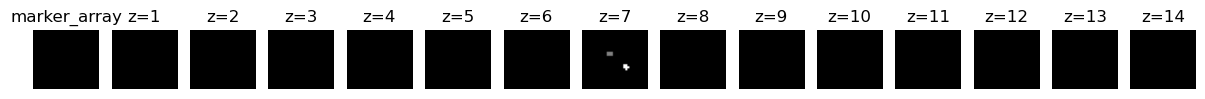

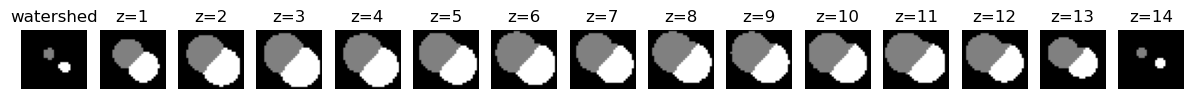

Processing label 4...
Only one conected component found for label 4, no markers for watershed applied.
Processing label 5...
Only one conected component found for label 5, no markers for watershed applied.
Processing label 6...


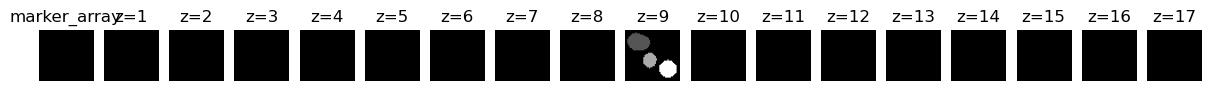

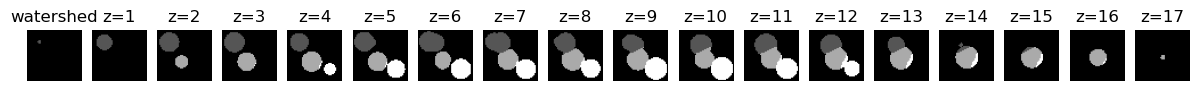

Processing label 7...


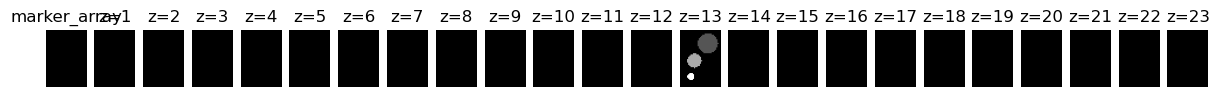

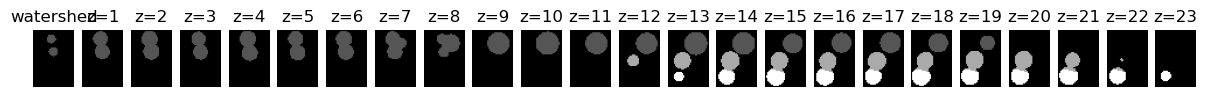

Processing label 8...
Only one conected component found for label 8, no markers for watershed applied.
Processing label 9...
Only one conected component found for label 9, no markers for watershed applied.
Processing C4-12012022_Label46_367L_Cd16_100x_0p21_01_scaled_oriScale.tif...
Processing label 1...


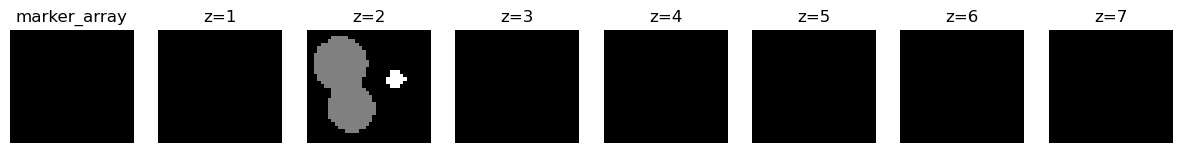

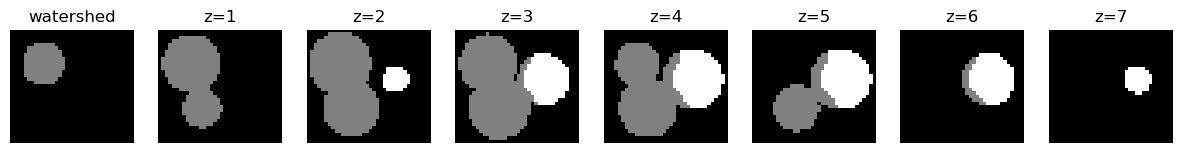

Processing C3-03022022_Label49_t1_100x_0p21_02_POS_current_scaled_oriScale.tif...
Processing label 1...


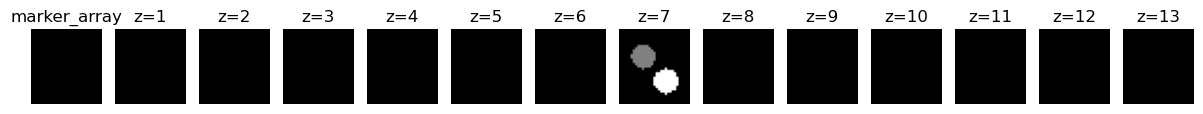

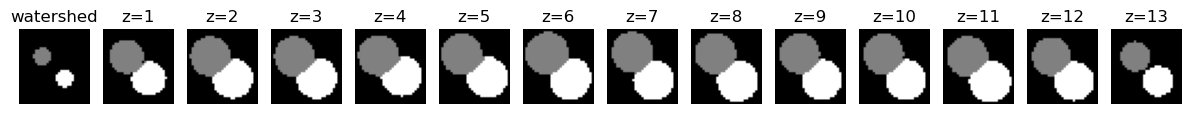

Processing label 2...
Only one conected component found for label 2, no markers for watershed applied.
Processing label 3...


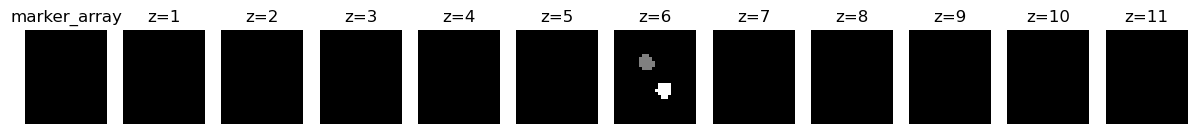

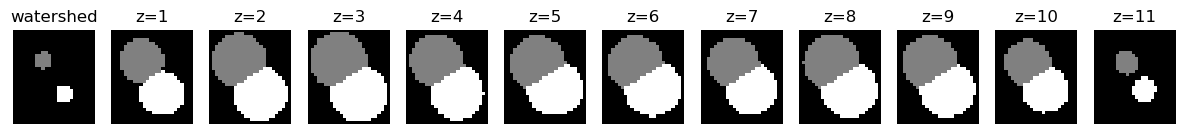

Processing label 4...


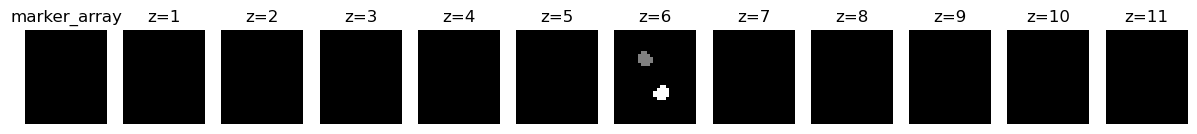

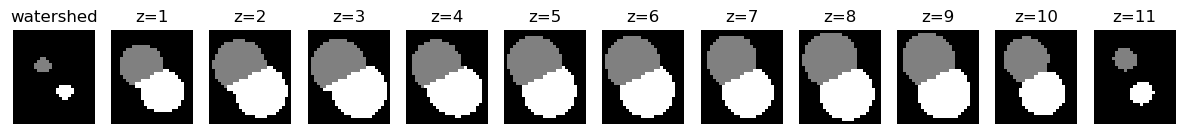

Processing C4-26012022_Label48_t1strep_100x_0p21_03_POS_current_scaled_oriScale.tif...
Processing label 1...
Only one conected component found for label 1, no markers for watershed applied.
Processing C4-16122021_Label45_367L_w3_1076_100x_0p21_01_scaled_oriScale 2.tif...
not label image
C4-16122021_Label45_367L_w3_1076_100x_0p21_01_scaled_oriScale 2.tif is likely not a label. Skipping...


In [ ]:
directory = "../../test_lbls"

# Get the list of label images in the directory
# The label images should be in .tif format and should not contain "relabel" in the name
# This is to avoid processing already relabeled images
lbl_image_list = [
    f for f in os.listdir(directory) if f.endswith(".tif") and "relabel" not in f
]

# Iterate over each label image in the directory
for lbl_image in lbl_image_list:
    print(f"Processing {lbl_image}...")
    # Get the label indices from the label image
    lbl_idx_list, original_array_shape = get_label_indices(directory, lbl_image)

    if lbl_idx_list is None:
        print(f"{lbl_image} is likely not a label image. Skipping...")
        continue

    # New array to store the relabeled labels
    # The shape is the same as the original label array
    lbl_array = np.zeros(original_array_shape, dtype=np.uint8)

    # Variable to count the number of relabeled labels
    # This is used to assign unique labels to the relabeled components
    re_lbl_count = 0

    # Iterate over each label in the label index list
    for i, lbl_idx in enumerate(lbl_idx_list):
        print(f"Processing label {i + 1}...")
        # Calculate the dimensions of the label from the indices
        # lbl_idx is a tuple of arrays (z, x, y) for the label
        # Adding 1 to the max value to include the last index
        x_dim = lbl_idx[1].max() - lbl_idx[1].min() + 1
        y_dim = lbl_idx[2].max() - lbl_idx[2].min() + 1
        z_dim = lbl_idx[0].max() - lbl_idx[0].min() + 1

        # Calculate the center of the label
        x_center = x_dim // 2 + 1
        y_center = y_dim // 2 + 1
        z_center = z_dim // 2

        # Create a zero array with the same shape as the label, with padding on xy dimensions
        # The padding is done to ensure that the label array has a border of zeros
        label_shape = (z_dim, x_dim + 2, y_dim + 2)
        label_array = np.zeros(label_shape, dtype=np.uint8)

        # Adjust the original indexes to fit the new label_array shape
        adjusted_z = lbl_idx[0] - lbl_idx[0].min()
        adjusted_x = lbl_idx[1] - lbl_idx[1].min() + 1
        adjusted_y = lbl_idx[2] - lbl_idx[2].min() + 1

        # Fill the label_array with the label number
        label_array[adjusted_z, adjusted_x, adjusted_y] = 1

        # Calculate the connected components in the label array
        connected_components_list, cc_array = calculate_connected_components(
            label_array
        )

        # If only one connected component is found, skip the watershed step
        # and continue to the next label
        if max(connected_components_list) == 1:
            print(
                f"Only one conected component found for label {i + 1}, no markers for watershed applied."
            )
            continue

        # Find the slice with the maximum number of connected components
        # This is done to ensure that the watershed algorithm has enough markers
        max_connected_components_idx = [
            i
            for i, x in enumerate(connected_components_list)
            if x == max(connected_components_list)
        ]

        # If no connected components are found, skip the watershed step
        # and continue to the next label
        if len(max_connected_components_idx) == 0:
            print(f"No connected components found for label {lbl_idx}.")
            continue

        else:
            marker_array = generate_label_marker_array(
                label_array,
                cc_array,
                max_connected_components_idx,
                z_center,
            )
        display_label_array(marker_array, title="marker_array")

        watersheded_array = watershed(
            image=label_array,
            markers=marker_array,
            mask=label_array,
            connectivity=26,
            compactness=0.001,
        )
        display_label_array(watersheded_array, title="watershed")

        lbl_array[lbl_idx] = (
            watersheded_array[adjusted_z, adjusted_x, adjusted_y] + re_lbl_count
        )
        re_lbl_count += max(connected_components_list)

    # Save the relabeled label array
    imsave(
        os.path.join(directory, f"relabel_{lbl_image}"),
        lbl_array.astype(np.uint16),
    )
